In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import preliz as pz
import pymc as pm
import pytensor.tensor as pt
from pydantic import BaseModel, ConfigDict

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
seed: int = 42
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [22]:
class PowerAnalysisConfig(BaseModel):
    effect_sizes: npt.NDArray
    sample_sizes: npt.NDArray
    n_simulations: int
    model_config = ConfigDict(arbitrary_types_allowed=True)


power_analysis_config = PowerAnalysisConfig(
    effect_sizes=np.linspace(0.01, 0.2, 10),
    sample_sizes=np.linspace(10, 450, 23, dtype=int),
    n_simulations=500,
)

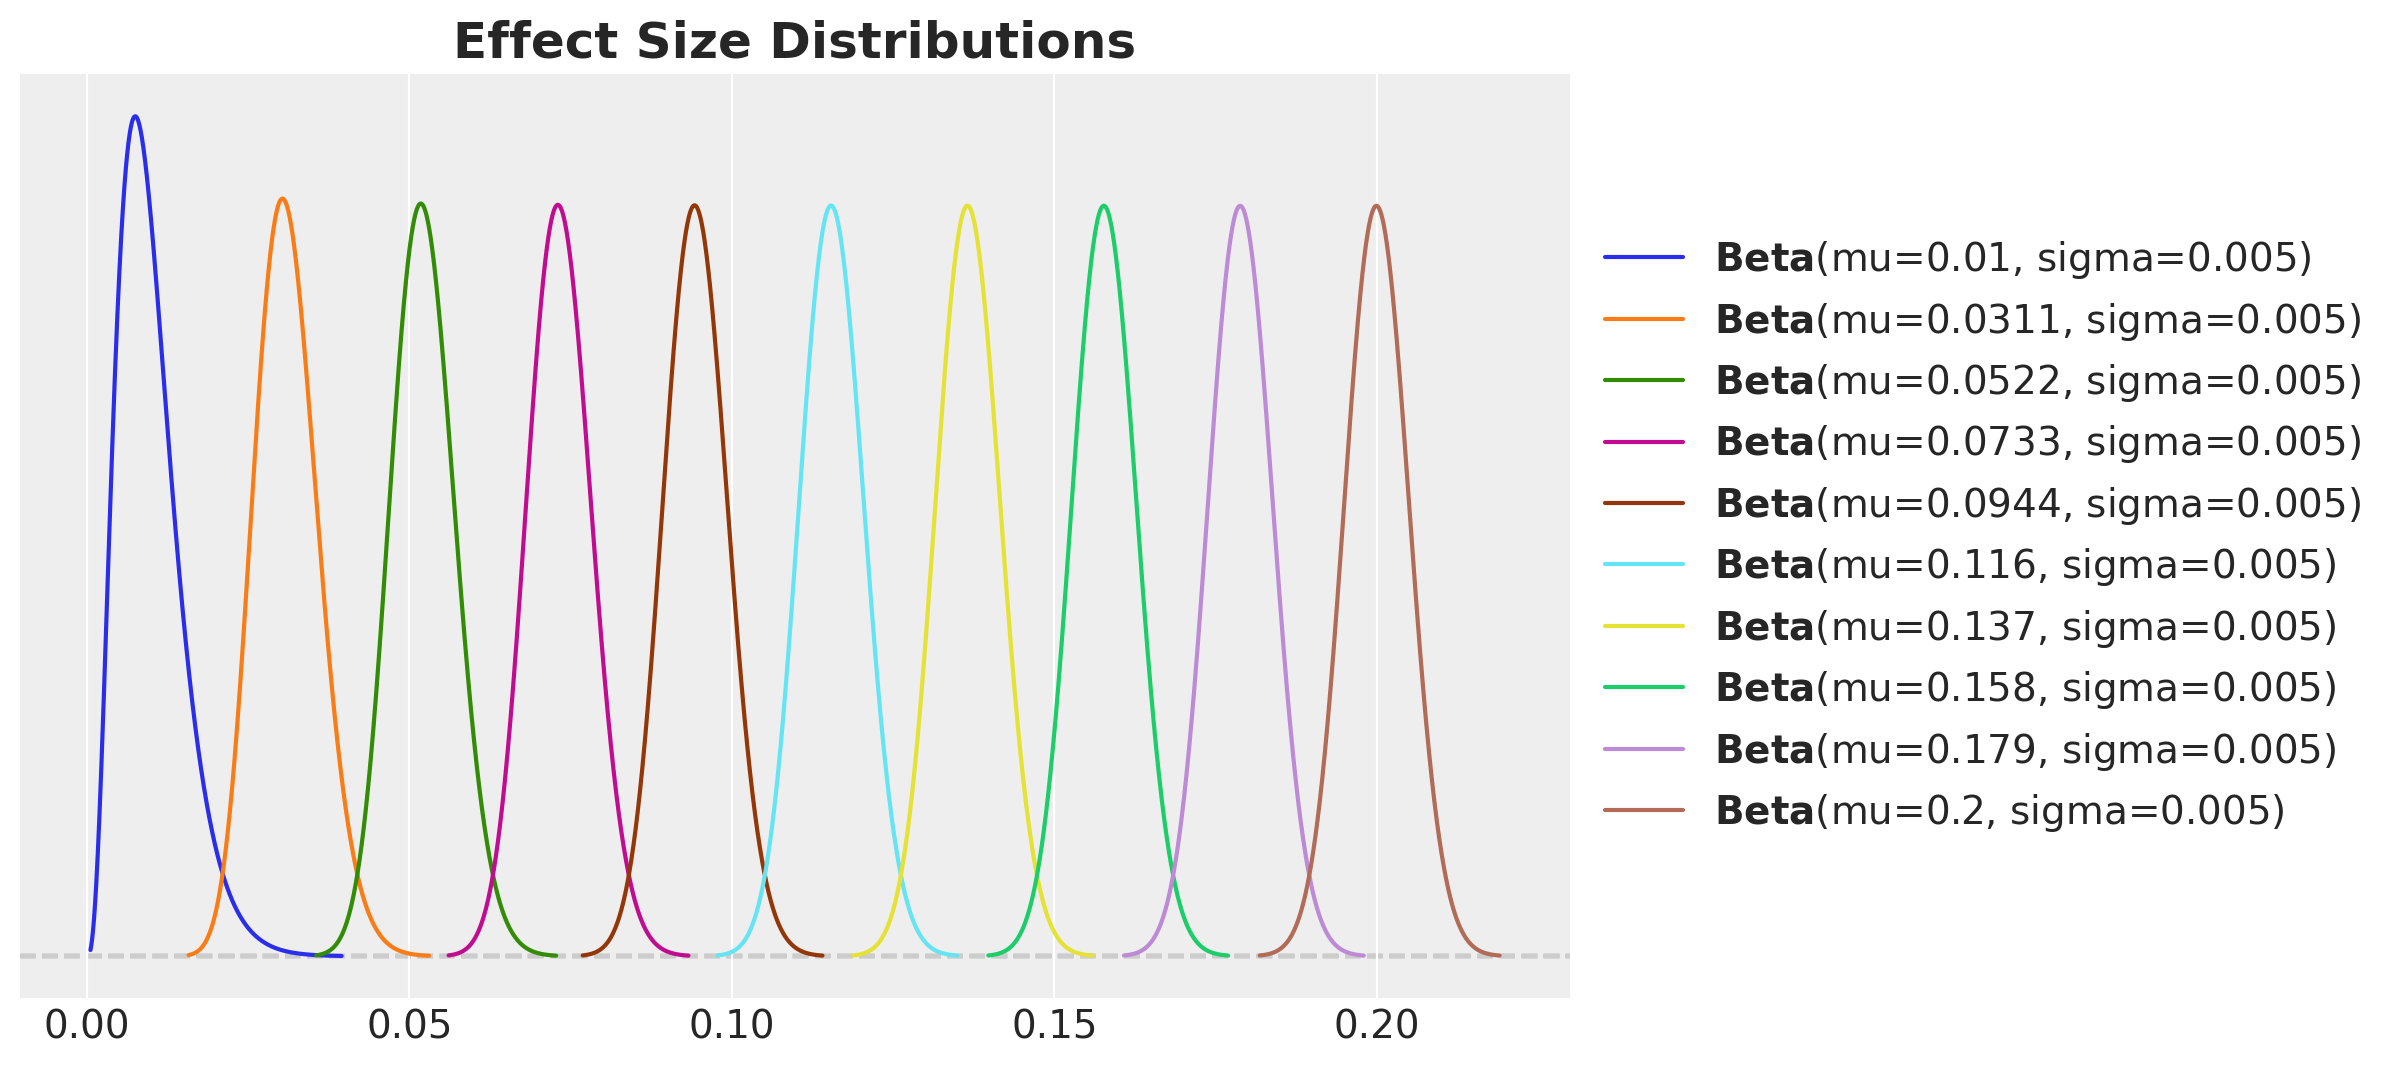

In [46]:
fig, ax = plt.subplots()

for effect_size in power_analysis_config.effect_sizes:
    pz.Beta(mu=effect_size, sigma=0.005).plot_pdf(ax=ax)

ax.set_title("Effect Size Distributions", fontsize=18, fontweight="bold");

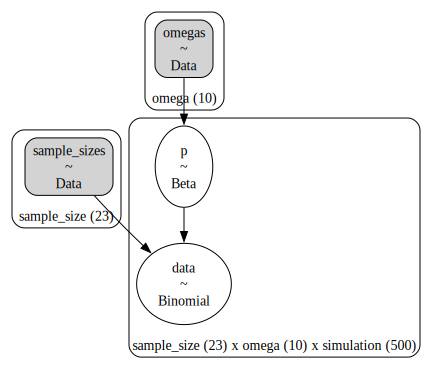

In [47]:
coords = {
    "sample_size": power_analysis_config.sample_sizes,
    "omega": power_analysis_config.effect_sizes,
    "simulation": range(power_analysis_config.n_simulations),
}

with pm.Model(coords=coords) as data_generating_model:
    # Data container for the sample sizes we want to consider.
    sample_sizes_ = pm.Data(
        "sample_sizes",
        power_analysis_config.sample_sizes,
        dims=("sample_size",),
    )
    # Expand the sample sizes to the shape of the model.
    sample_sizes_expanded = pt.expand_dims(
        pt.as_tensor_variable(sample_sizes_), axis=[1, 2]
    )
    # Data container for the omegas we want to consider.
    omegas_ = pm.Data("omegas", power_analysis_config.effect_sizes, dims=("omega",))
    # Expand the omegas to the shape of the model.
    omegas_expanded = pt.expand_dims(pt.as_tensor_variable(omegas_), axis=[0, 2])
    # Sample from the hypothetical distribution.
    p = pm.Beta(
        "p",
        mu=omegas_expanded,
        sigma=0.005,
        dims=("sample_size", "omega", "simulation"),
    )
    # Generate the data from the binomial distribution.
    pm.Binomial(
        "data",
        n=sample_sizes_expanded,
        p=p,
        dims=("sample_size", "omega", "simulation"),
    )

pm.model_to_graphviz(data_generating_model)